In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from more_itertools import flatten
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from dhdrnet.util import ROOT_DIR

In [20]:
stats_df = pd.read_csv(ROOT_DIR/'precomputed_data' / 'store.csv')
stats_df = stats_df.set_index(["name"])
stats_df

,metric,ev1,ev2,score
name,,,,
0127_20161022_152006_986,mse,-4.0,-2.0,14704.385687
0127_20161022_152006_986,ssim,-4.0,-2.0,0.275291
0127_20161022_152006_986,mse,-4.0,0.0,5048.177722
0127_20161022_152006_986,ssim,-4.0,0.0,0.697481
0127_20161022_152006_986,mse,-4.0,2.0,248.040429
...,...,...,...,...
33TJ_20150730_201700_327,ssim,0.0,3.0,0.946976
33TJ_20150730_201700_327,mse,0.0,6.0,1843.886157
33TJ_20150730_201700_327,ssim,0.0,6.0,0.774936


In [24]:
stats_df.groupby("metric").get_group("mse")

,metric,ev1,ev2,score
name,,,,
0127_20161022_152006_986,mse,-4.0,-2.0,14704.385687
0127_20161022_152006_986,mse,-4.0,0.0,5048.177722
0127_20161022_152006_986,mse,-4.0,2.0,248.040429
0127_20161022_152006_986,mse,-4.0,4.0,1042.619561
0127_20161022_152006_986,mse,-2.0,0.0,6022.183729
...,...,...,...,...
33TJ_20150730_201700_327,mse,-3.0,3.0,243.156253
33TJ_20150730_201700_327,mse,-3.0,6.0,3363.090232
33TJ_20150730_201700_327,mse,0.0,3.0,246.018017


In [44]:
pd.unique(stats_df[["ev1", "ev2"]].values.ravel("K"))

array(['-4.0', '-2.0', '0.0', '2.0', '-5.0', '-2.5', '2.5', '-6.0',
       '-3.0', '3.0', 'ev2', '4.0', '5.0', '6.0', 'score'], dtype=object)

In [52]:
stats_df[stats_df["ev1"].isin(["ev2"])]

,metric,ev1,ev2,score
name,,,,
metric,ev1,ev2,score,NaN
metric,ev1,ev2,score,NaN
metric,ev1,ev2,score,NaN
metric,ev1,ev2,score,NaN
metric,ev1,ev2,score,NaN
...,...,...,...,...
metric,ev1,ev2,score,NaN
metric,ev1,ev2,score,NaN
metric,ev1,ev2,score,NaN


In [59]:
bad = stats_df.loc["metric"]

In [267]:
stats_clean = stats_df.loc[stats_df.index.difference(bad.index)]
stats_clean = stats_clean.drop_duplicates()
stats_clean.to_csv(ROOT_DIR/"precomputed_data"/"stats_clean.csv")
stats = stats_clean

In [268]:
stats[["ev1", "ev2"]] = stats[["ev1", "ev2"]].apply(pd.to_numeric)
bsdf = pd.concat([stats[stats[ev] == 0] for ev in ["ev1", "ev2"]])

In [269]:
bsdf

,metric,ev1,ev2,score
name,,,,
0006_20160721_163256_525,mse,0.0,2.0,163.995115
0006_20160721_163256_525,ssim,0.0,2.0,0.969672
0006_20160721_163256_525,mse,0.0,4.0,415.541140
0006_20160721_163256_525,ssim,0.0,4.0,0.960854
0006_20160721_163256_525,mse,0.0,2.5,115.394008
...,...,...,...,...
synthetic_ramp_night,ssim,-2.5,0.0,0.838293
synthetic_ramp_night,mse,-6.0,0.0,1527.866328
synthetic_ramp_night,ssim,-6.0,0.0,0.858638


In [266]:
ev = bsdf[["ev1","ev2"]].where(bsdf[["ev1", "ev2"]] != 0, other=None)
def replace_none(row):
    if row.iloc[0]:
        return row.iloc[0]
    else:
        return row.iloc[1]
    
bsdf["ev"] = ev.apply(replace_none, axis=1)
bsdf = bsdf.drop(["ev1", "ev2"],axis=1)

KeyError: "None of [Index(['ev1', 'ev2'], dtype='object')] are in the [columns]"

In [219]:
bsdf.to_csv(ROOT_DIR/"precomputed_data" / "baseline_stats.csv")

In [222]:
bsdf["ev"].unique()

array([ 2. ,  4. ,  2.5,  5. ,  3. ,  6. , -4. , -2. , -5. , -2.5, -6. ,
       -3. ])

In [229]:
bsdf4 = bsdf[bsdf["ev"].isin(np.linspace(-4,4,5))]
bsdf5 = bsdf[bsdf["ev"].isin(np.linspace(-5,5,5))] 
bsdf6 = bsdf[bsdf["ev"].isin(np.linspace(-6,6,5))]

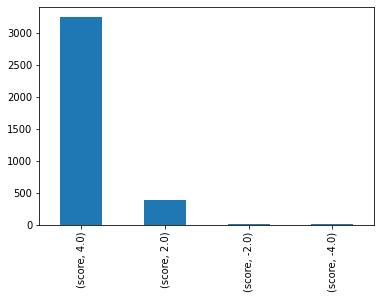

In [262]:
mse_opt4 = (
    bsdf4.groupby("metric")
        .get_group("mse")
        .pivot(columns="ev")
        .drop("metric", axis=1)
        .idxmin(axis=1)
)
mse_opt4.value_counts().plot.bar()

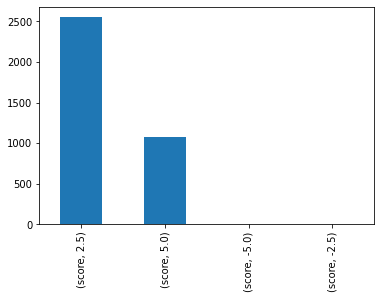

In [263]:
mse_opt5 = (
    bsdf5.groupby("metric")
        .get_group("mse")
        .pivot(columns="ev")
        .drop("metric", axis=1)
        .idxmin(axis=1)
)
mse_opt5.value_counts().plot.bar()

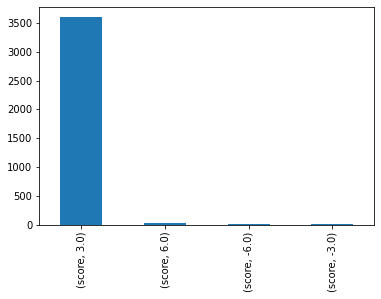

In [264]:
mse_opt6 = (
    bsdf6.groupby("metric")
        .get_group("mse")
        .pivot(columns="ev")
        .drop("metric", axis=1)
        .idxmin(axis=1)
)
mse_opt6.value_counts().plot.bar()


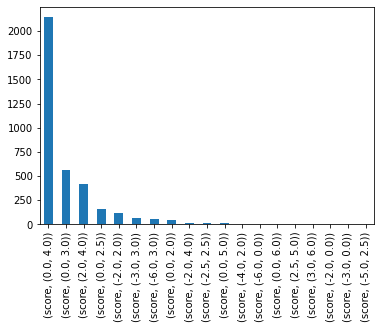

In [307]:
all_opt = (
    stats.groupby("metric")
        .get_group("mse")
        .copy()
)
all_opt["ev"] = (
    all_opt.loc[:,["ev1", "ev2"]]
        .apply(lambda df: tuple(sorted((df.iloc[0], df.iloc[1]))),axis=1)
)
all_opt = all_opt.pivot(columns="ev").drop(columns=["metric", "ev1", "ev2"])
all_opt.idxmin(axis=1).value_counts().plot.bar()